In [116]:
import numpy as np
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [117]:
def read_file(file_name):
    file = open(file_name, "r")
    list_string = []
    i = 0
    while True:
        line = file.readline()
        list_string.append(line)
        if not line:
            break
        file.close
    return list_string

In [118]:
file_name = "Sim4MLX.dat"
main_data = []
list_string = read_file(file_name)
# last string is empty
list_string.pop()

''

In [119]:
# Parse data
param_data = []
signal_data = []
for string in list_string:
    data = np.fromstring(string, dtype=float, sep=' ')
    # Removing the row index at the beggining as it's redundant
    data = np.delete(data, 0)
    
    resistance_depth = data[:7]
    param_data.append(resistance_depth)

    # Up to 56 index, because value for 57 index is zero
    signal_values = np.log(data[7:56])
    signal_data.append(signal_values)

In [120]:
len(signal_data)


1000037

In [6]:
#Direct problem: by params predict signals

# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)



In [ ]:
# Split data into train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.67, 
                                                    random_state=42)

regr = linear_model.LinearRegression()

# Fit model
regr.fit(params_train, signal_train)

In [7]:
signal_pred = regr.predict(params_test)
print("Mean squared error: %.25f" % mean_squared_error(signal_test[0], signal_pred[0]))
print("Coefficient of determination: %.2f" % r2_score(signal_test, signal_pred))
# Result is 0.49 - not bad and not good, if take non-log signal
# Result is 0.59 - better, if take logarithmic signal

Mean squared error: 0.2309464399367011921970771
Coefficient of determination: 0.53


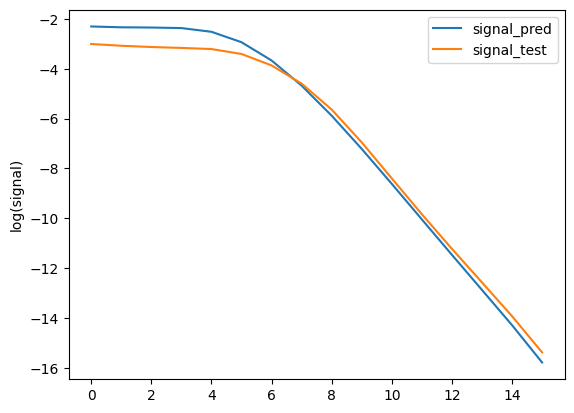

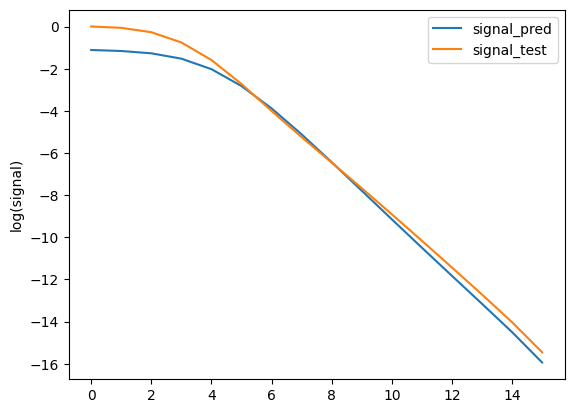

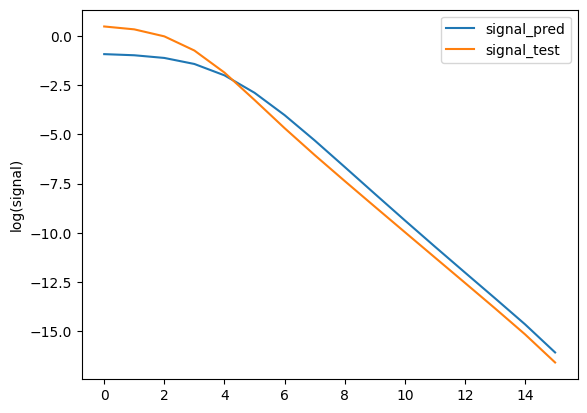

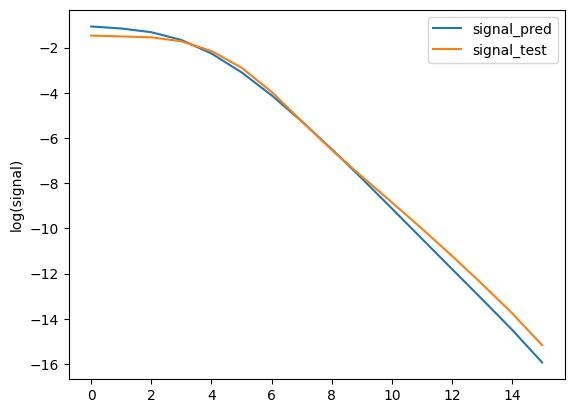

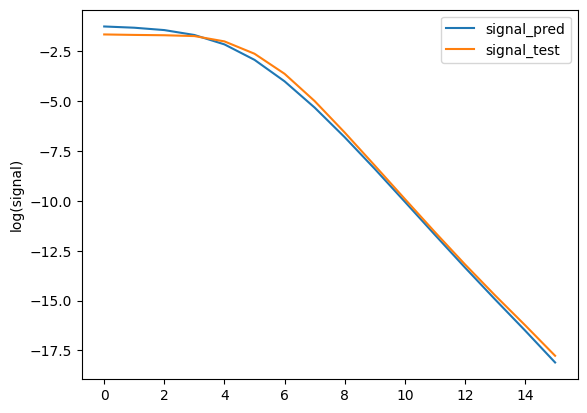

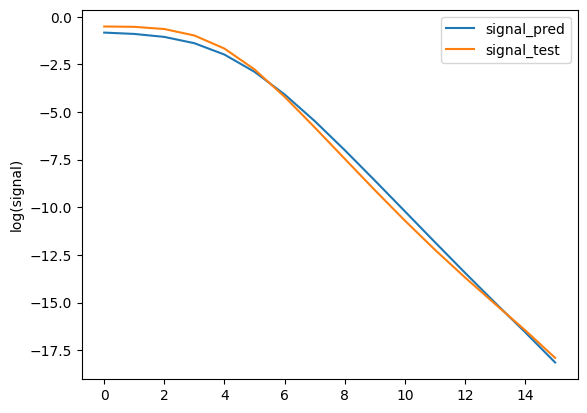

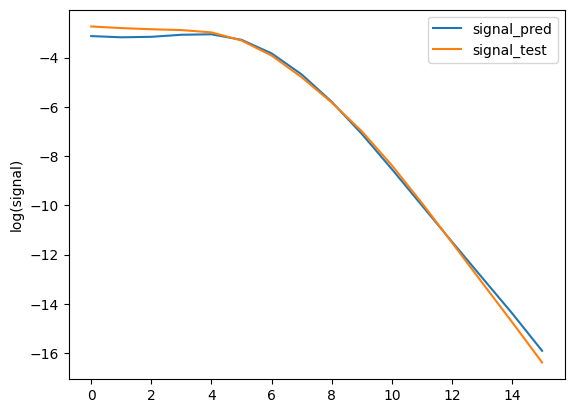

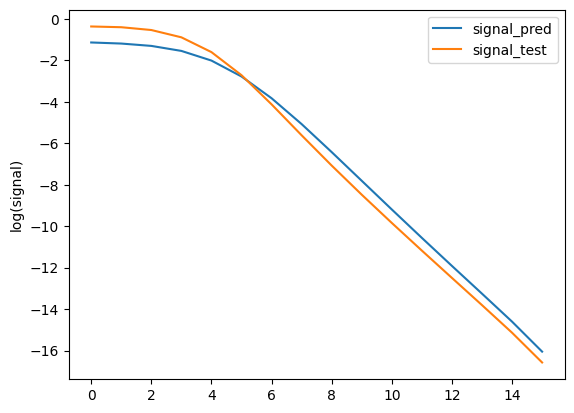

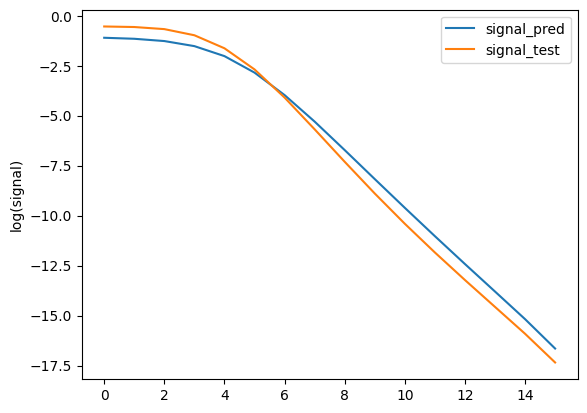

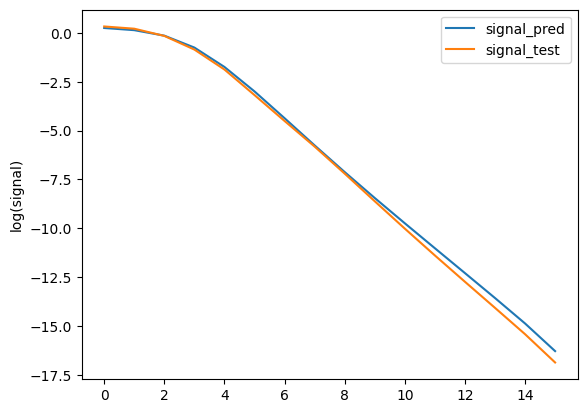

In [8]:
# Visualize 10 first pred and test signals
for i in range (10):
    plt.plot(signal_pred[i], label='signal_pred')
    plt.plot(signal_test[i], label='signal_test')
    plt.legend()
    plt.ylabel('log(signal)')
    plt.show()

In [7]:
# Inverse problem: by signal predict parameters

# Scale data
scaler = StandardScaler().fit(signal_data)
signal_data_scaled = scaler.transform(signal_data)


In [ ]:
# Split data to train and test
signal_train, signal_test, params_train, params_test = train_test_split(signal_data_scaled, param_data, 
                                                    train_size=0.67, 
                                                    random_state=42)
regr = linear_model.LinearRegression()
# Fit model
regr.fit(signal_train, params_train)

In [10]:
params_pred = regr.predict(signal_test)
print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
## Coef is too low, linear regression is a bad choice

Mean squared error: 19679.7497772198912571184337139
Coefficient of determination: 0.26


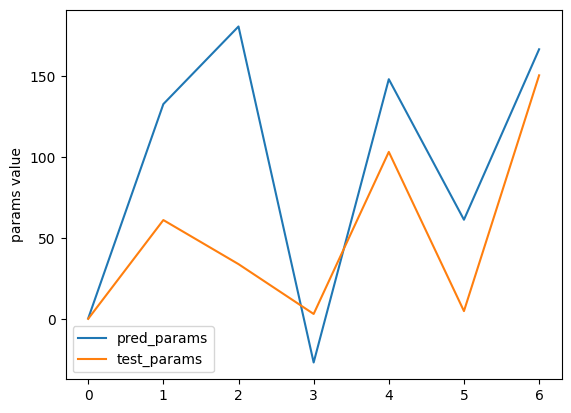

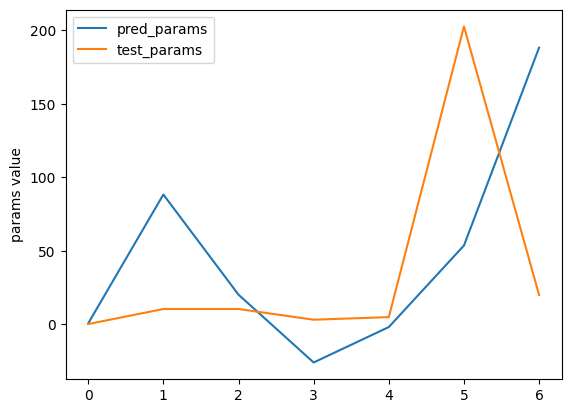

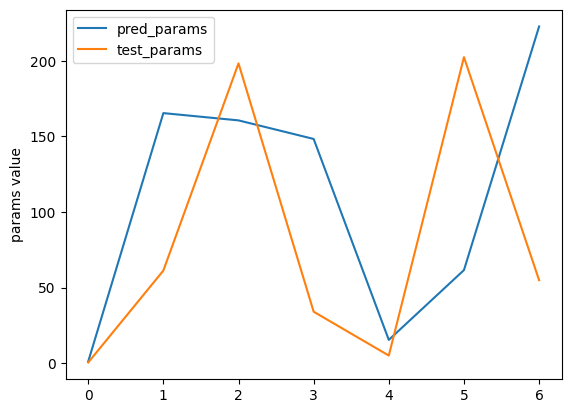

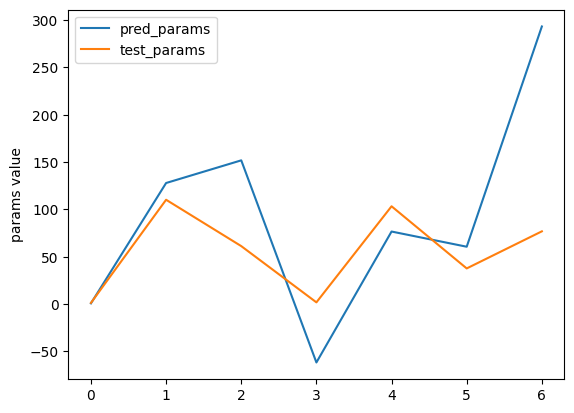

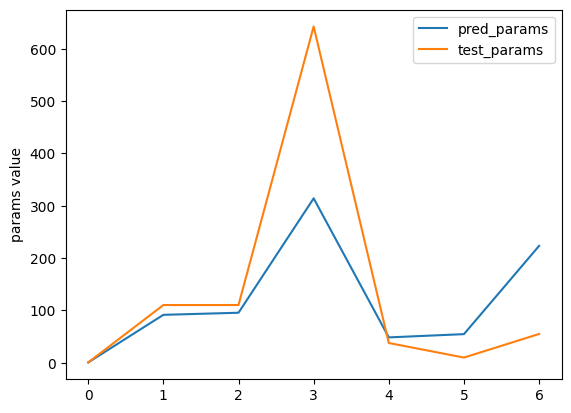

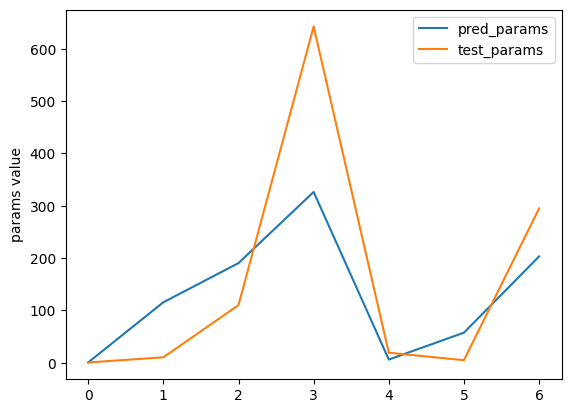

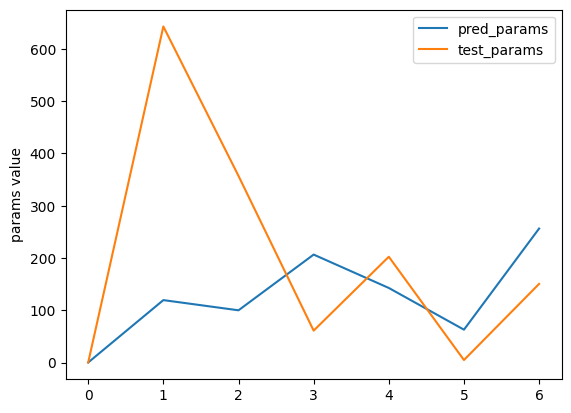

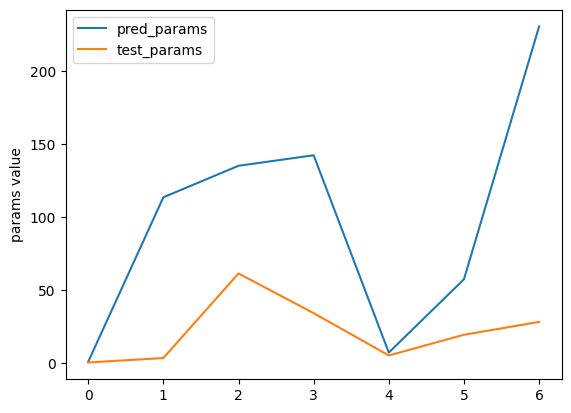

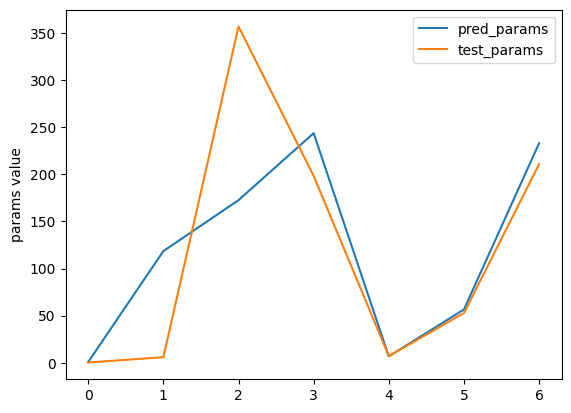

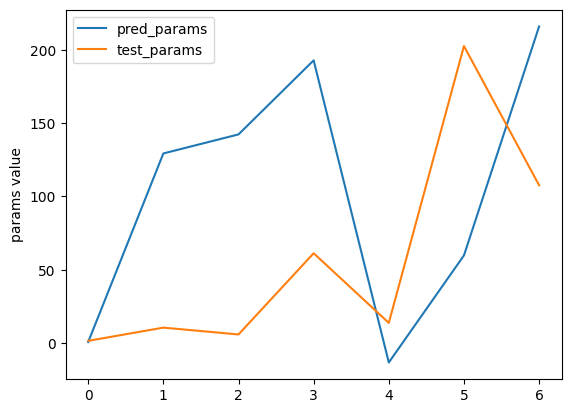

In [11]:
# Visualize 10 first pred and test params
for i in range (10):
    plt.plot(params_pred[i], label='pred_params')
    plt.plot(params_test[i], label='test_params')
    plt.legend()
    plt.ylabel('params value')
    plt.show()

In [12]:
# Вывод: для обратной задачи линейная регрессия плоха как с прологарифмированным, так и с обычным сигналом
# для прямой - если для обучения брать прологарифмированный сигнал, но на тесте линейная регрессия показывает
# результат лучше, чем если бы сигнал не был прологарифмирован

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [13]:


# Scale data
scaler = StandardScaler().fit(param_data)
param_data_scaled = scaler.transform(param_data)

# Split data into train and test
params_train, params_test, signal_train, signal_test = train_test_split(param_data_scaled, signal_data, 
                                                    train_size=0.75, 
                                                    random_state=42)

#regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
# не получается обучить на всем датасете, ядро отваливается, приходится делать батчами
# и запоминать результат с помощью warm_start=true
#regressor.fit(params_train, signal_train)


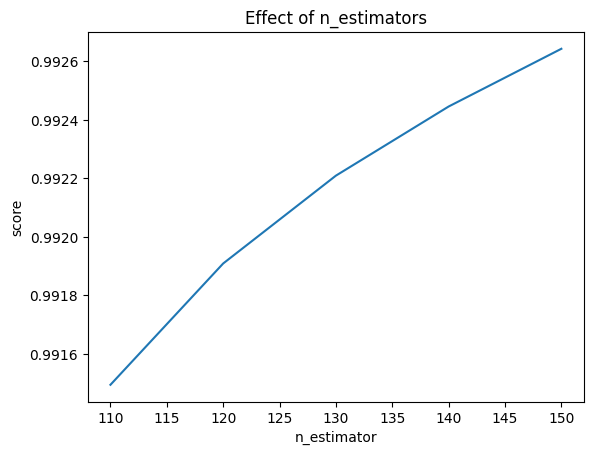

In [14]:
# warm_start = True is needed to 
# reuse the solution of the previous call to fit and add more estimators to the ensemble
regressor = RandomForestRegressor(n_estimators = 100, warm_start = True, n_jobs=-1,random_state=42)

scores = []
estimators = []

for params_train_split, signal_train_split in zip(np.array_split(params_train, 5), np.array_split(signal_train, 5)): # split into 500 dataframes 
    regressor.fit(params_train_split, signal_train_split)
    regressor.n_estimators += 10
    scores.append(regressor.score(params_test, signal_test))
    estimators.append(regressor.n_estimators)
    
    
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)
    
    

In [15]:
signal_pred = regressor.predict(params_test)
print("Mean squared error: %.25f" % mean_squared_error(signal_test[0], signal_pred[0]))
print("Coefficient of determination: %.2f" % r2_score(signal_test, signal_pred))
print("Model score:  %.25f" %regressor.score(params_test, signal_test))
# Coefficient 0.99

Mean squared error: 0.0000270236262790669859641
Coefficient of determination: 0.99
Model score:  0.9926426366007906620936296


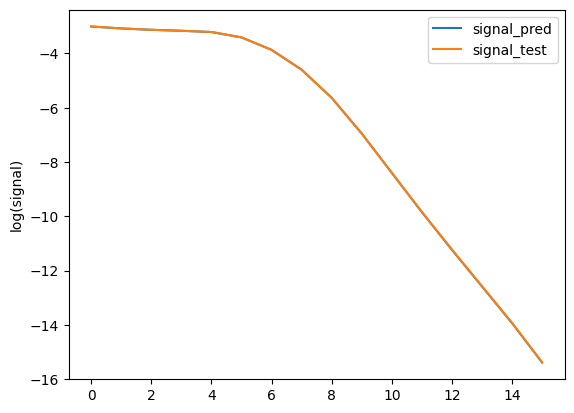

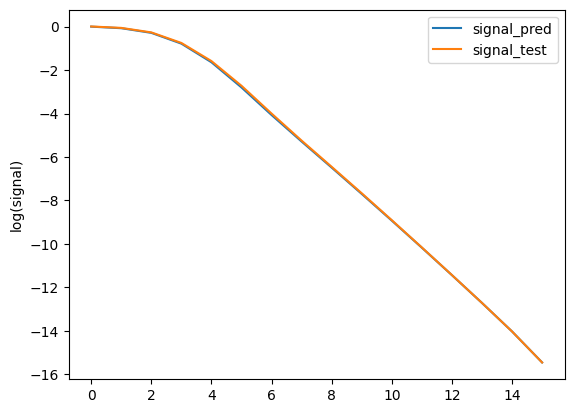

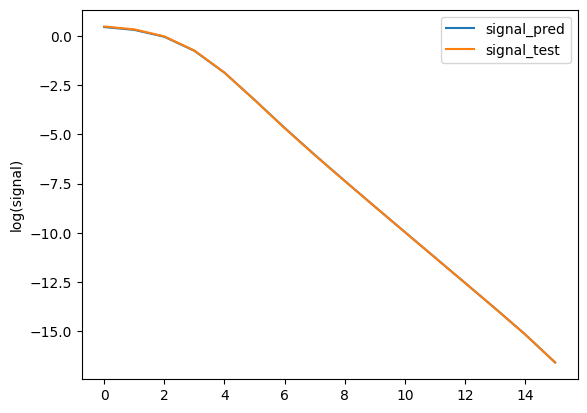

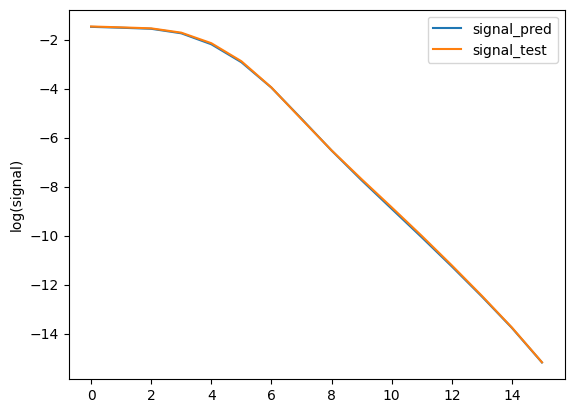

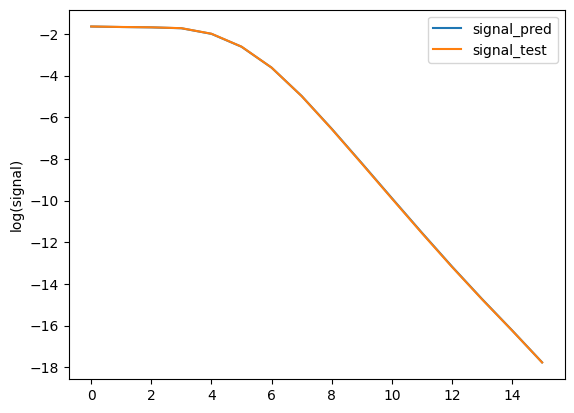

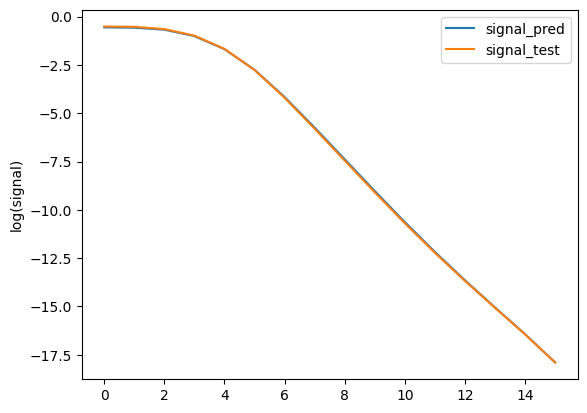

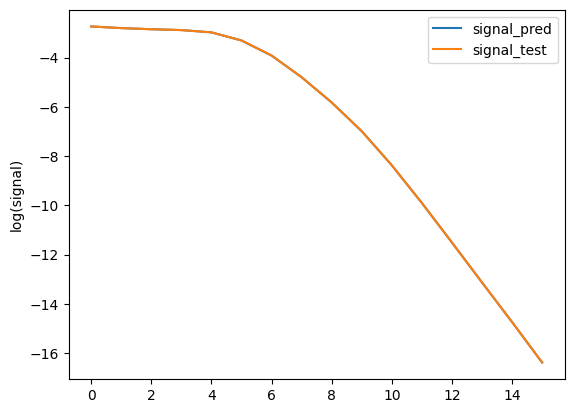

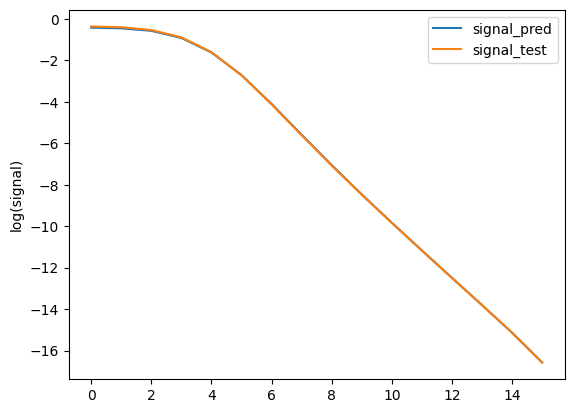

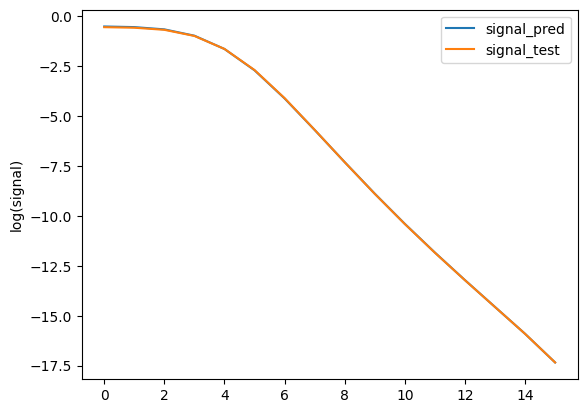

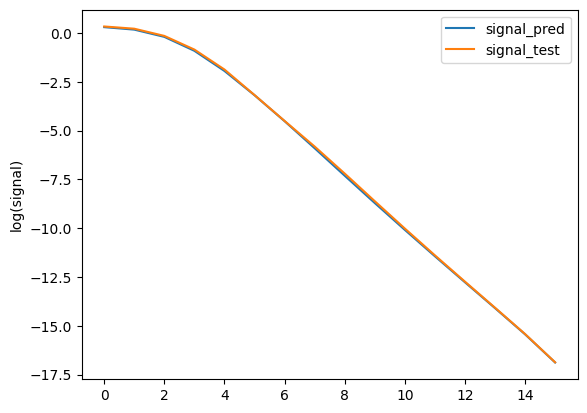

In [16]:
# Visualize 10 first pred and test signals
for i in range (10):
    plt.plot(signal_pred[i], label='signal_pred')
    plt.plot(signal_test[i], label='signal_test')
    plt.legend()
    plt.ylabel('log(signal)')
    plt.show()

In [18]:
# Inverse problem: by signal predict parameters
# Done in python script to prevent kernel death
#Xgboost is also bad solution


#from xgboost import XGBRegressor

# Split data to train and test
"""
signal_train, signal_test, params_train, params_test = train_test_split(signal_data_scaled, param_data,
                                                    train_size=0.6,
                                                    random_state=42)
xgb_regressor = XGBRegressor(n_estimators=100, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
"""
#regressor.fit(signal_train, params_train)



In [19]:
#xgb_regressor.fit(signal_train, params_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, ...)

In [21]:
"""
params_pred = xgb_regressor.predict(signal_test)

print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
print("Model score:  %.25f" %xgb_regressor.score(signal_test, params_test))
"""

Mean squared error: 11638.2579206941336451563984156
Coefficient of determination: 0.59
Model score:  0.5912110443913055624065578


In [12]:
#params_pred = regressor.predict(signal_test)
#print("Mean squared error: %.25f" % mean_squared_error(params_test, params_pred))
#print("Coefficient of determination: %.2f" % r2_score(params_test, params_pred))
#print("Model score:  %.25f" %regressor.score(signal_test, params_test))
# Можем улучшить коэффициент, если тестовая выборка будет больше,
# чем 0.1, но в колабе ограничения на озу не позволяют 

Mean squared error: 10270.9250615738892520312219858
Coefficient of determination: 0.61
Model score:  0.6134330224204862513914804


In [ ]:
########################################################################

In [121]:
# Try to solve inverse problem by feed forward network
import torch
import torch.nn as nn
print(torch.cuda.is_available())


True


In [122]:
device = torch.device('cuda')
device

device(type='cuda')

In [151]:
scaler = StandardScaler().fit(signal_data)
signal_data_scaled = scaler.transform(signal_data)

signal_train, signal_test, params_train, params_test = train_test_split(signal_data_scaled, param_data, 
                                                    train_size=0.05, 
                                                    random_state=42)


In [152]:
signal_train_torch = torch.FloatTensor(signal_train)
signal_test_torch  = torch.FloatTensor(signal_test)
params_train_torch = torch.FloatTensor(params_train)
params_test_torch  = torch.FloatTensor(params_test)

signal_train_torch = signal_train_torch.to(device)
signal_test_torch  = signal_test_torch.to(device)
params_train_torch = params_train_torch.to(device)
params_test_torch  = params_test_torch.to(device)

In [153]:
signal_test_torch.is_cuda

True

In [154]:
n_input  = signal_train_torch.size()[1]
n_output = params_train_torch.size()[1]

print(n_input)
print(n_output)


learning_rate = 0.01

16
7


In [172]:
class Feedforward(nn.Module):
        def __init__(self, input_size, output_size):
            super(Feedforward, self).__init__()
            self.input_size = input_size
            self.output_size = output_size
            
            self.relu = nn.ReLU()            
            self.sigmoid = nn.Sigmoid()
            
            self.fc1 = nn.Sequential(nn.Linear(input_size, 30),
                                     self.relu) 
            
            self.fc2 = nn.Sequential(nn.Linear(30, 15),
                                     self.relu)
            self.fc3 = nn.Sequential(nn.Linear(15, 10), 
                                     self.relu)
            self.fc4 = nn.Sequential(nn.Linear(10, self.output_size),
                                     self.sigmoid)
            

        def forward(self, x):
            out = self.fc1(x)
            out = self.fc2(out)
            out = self.fc3(out)
            out = self.fc4(out)
            
            return out

In [173]:
model = Feedforward(n_input, n_output)
model.to(device)

Feedforward(
  (relu): ReLU()
  (sigmoid): Sigmoid()
  (fc1): Sequential(
    (0): Linear(in_features=16, out_features=30, bias=True)
    (1): ReLU()
  )
  (fc2): Sequential(
    (0): Linear(in_features=30, out_features=15, bias=True)
    (1): ReLU()
  )
  (fc3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): ReLU()
  )
  (fc4): Sequential(
    (0): Linear(in_features=10, out_features=7, bias=True)
    (1): Sigmoid()
  )
)

In [174]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.MSELoss()
signal_train_torch.size()

torch.Size([50001, 16])

In [175]:
losses = []
LOG_EVERY_N = 1000
i = 0

model.train()
for epoch in range(1):

    for signal_tr, params_tr in zip(signal_train_torch, params_train_torch):
        optimizer.zero_grad()

        pred_params = model(signal_tr)
        loss = loss_fn(pred_params, params_tr)
        losses.append(loss.item())
        
        if i % LOG_EVERY_N == 0:
            print('i {}: train loss: {}'.format(i, loss.item()))
    
        loss.backward()
    
        optimizer.step()
        i = i + 1
    

i 0: train loss: 726.9603881835938
i 1000: train loss: 2079.515380859375
i 2000: train loss: 1918.0374755859375
i 3000: train loss: 1322.56640625
i 4000: train loss: 1336.873291015625
i 5000: train loss: 1674.7664794921875
i 6000: train loss: 2293.46728515625
i 7000: train loss: 1660.0545654296875
i 8000: train loss: 1740.77392578125
i 9000: train loss: 1843.927490234375
i 10000: train loss: 948.6341552734375
i 11000: train loss: 2009.5858154296875
i 12000: train loss: 1578.5076904296875
i 13000: train loss: 1684.87841796875
i 14000: train loss: 787.260498046875
i 15000: train loss: 1532.8486328125
i 16000: train loss: 947.3817138671875
i 17000: train loss: 1117.196533203125
i 18000: train loss: 1181.26123046875
i 19000: train loss: 314.4503173828125
i 20000: train loss: 2398.813232421875
i 21000: train loss: 783.2548828125
i 22000: train loss: 1175.5518798828125
i 23000: train loss: 2486.299072265625
i 24000: train loss: 576.9008178710938
i 25000: train loss: 1324.70361328125
i 26000:

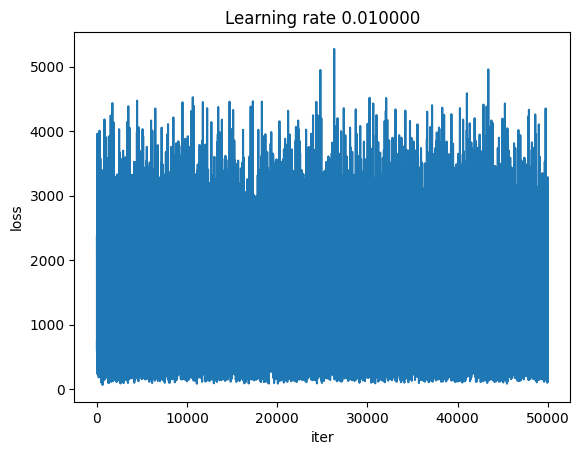

In [176]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('loss')
plt.xlabel('iter')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

# Модель не обучается

In [177]:
model.eval()
criterion = nn.BCELoss()

#for signal_test, params_test in zip(signal_test_torch, params_test_torch):
params_pred = model(signal_test_torch[0])
after_train = criterion(params_pred, params_test_torch[0]) 
print('Test loss after Training' , after_train.item())

Test loss after Training -1871.9957275390625


In [178]:
pred_params = []
i = 0
for signal, params in zip(signal_test_torch, params_test_torch):
    pred = model(signal)
    pred = pred.cpu().detach().numpy()
    pred_params.append(pred)
    i = i + 1
    if i == 10:
        break

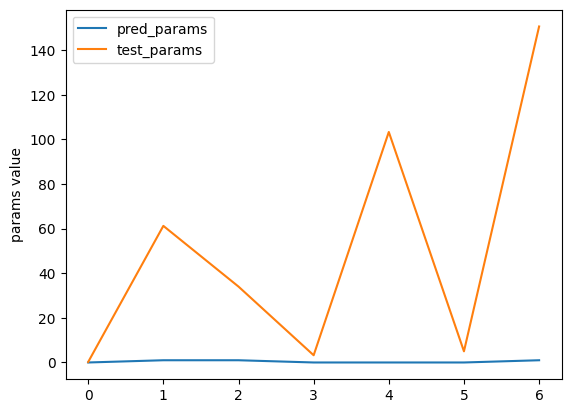

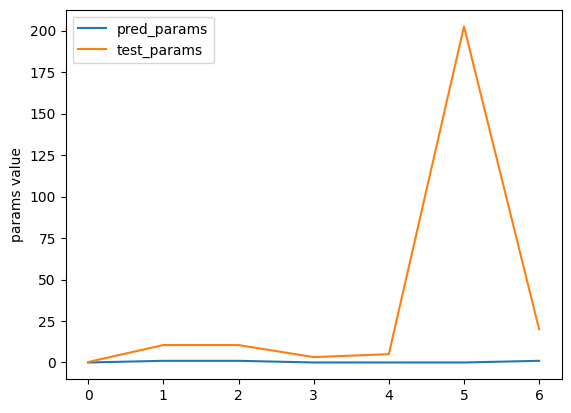

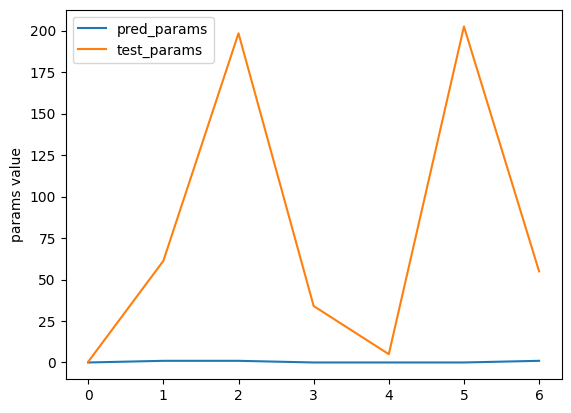

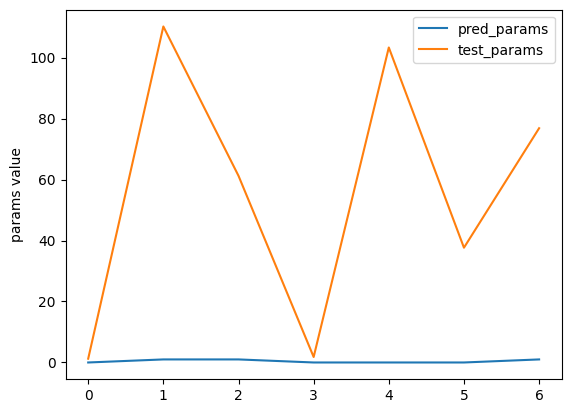

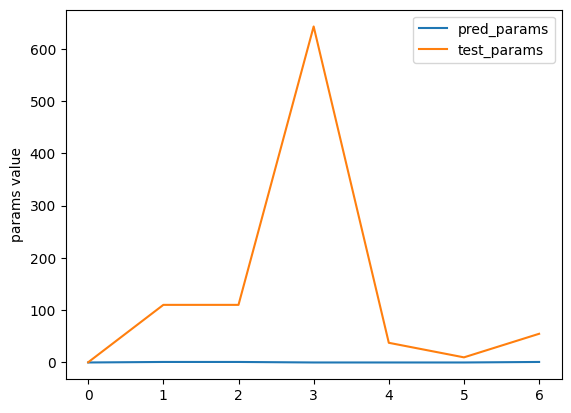

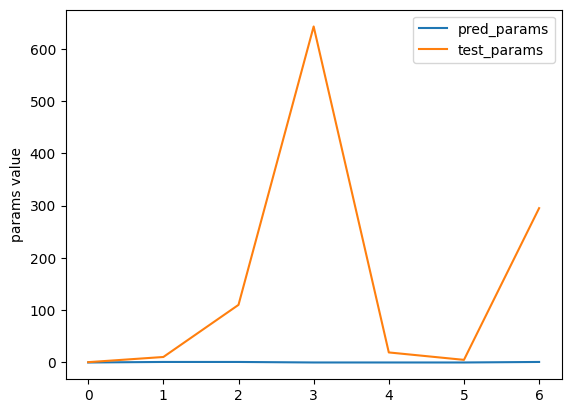

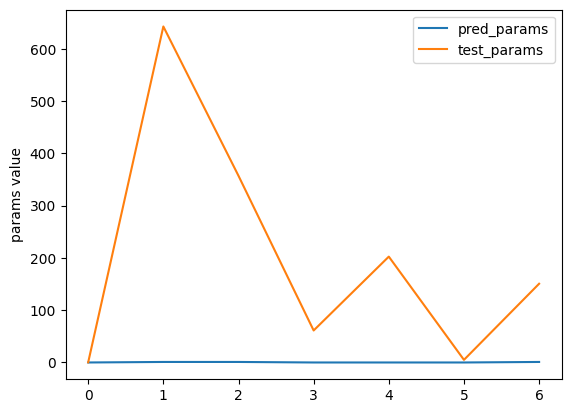

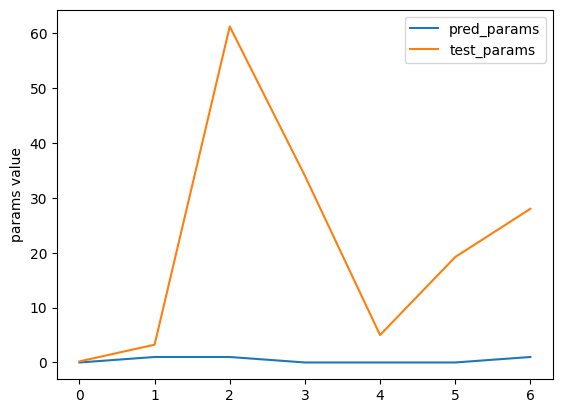

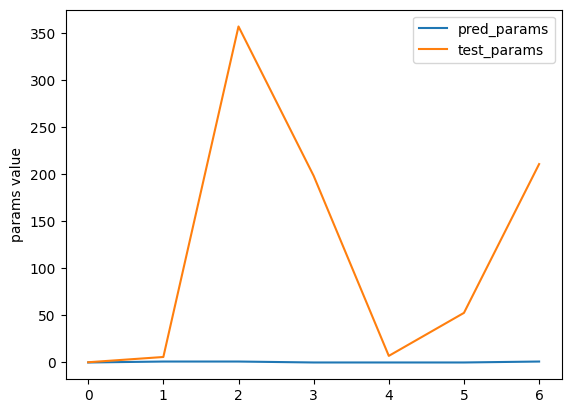

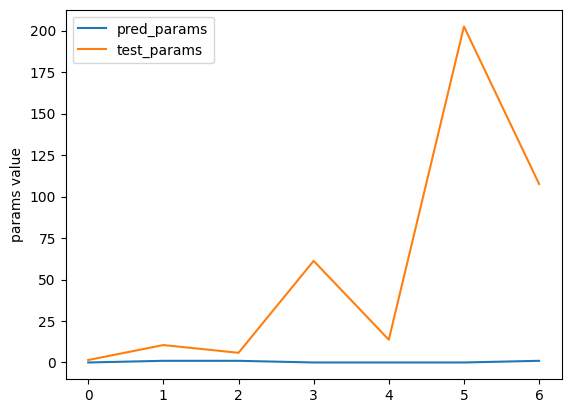

In [179]:
# Visualize 10 first pred and test params
#pred_params
for i in range (10):
    plt.plot(pred_params[i], label='pred_params')
    plt.plot(params_test[i], label='test_params')
    plt.legend()
    plt.ylabel('params value')
    plt.show()

In [96]:
# Try RNN model
"""
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)
        
        print("Batch size: ", batch_size)

        # Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        print("Before x", x.size())
        print("Hidden", hidden.size())
        out, hidden = self.rnn(x, hidden)
        print("Out: ", out)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [97]:
"""
rnn_model = Model(input_size=n_input, output_size=n_output, hidden_dim=12, n_layers=1)
rnn_model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [167]:
# Training Run
"""
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    
    x_3D = signal_train_torch.unsqueeze(2)
    x_3D = signal_train_torch.repeat(1,1,1024).reshape(16,1024,1024)
    output = rnn_model(signal_train_torch)
    loss = criterion(output, params_train_torch)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))
"""

'\nfor epoch in range(1, n_epochs + 1):\n    optimizer.zero_grad() # Clears existing gradients from previous epoch\n\n    \n    x_3D = signal_train_torch.unsqueeze(2)\n    x_3D = signal_train_torch.repeat(1,1,1024).reshape(16,1024,1024)\n    output = rnn_model(signal_train_torch)\n    loss = criterion(output, params_train_torch)\n    loss.backward() # Does backpropagation and calculates gradients\n    optimizer.step() # Updates the weights accordingly\n    \n    if epoch%10 == 0:\n        print(\'Epoch: {}/{}.............\'.format(epoch, n_epochs), end=\' \')\n        print("Loss: {:.4f}".format(loss.item()))\n'